# Textual analysis of MD data

## Prerequise packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Analysis of the length of descriptive texts

In [2]:
# Load data
datasets = pd.read_parquet(
    "https://sandbox.zenodo.org/record/1169962/files/datasets.parquet"
)
# Create a text column and text length column
df = datasets.copy()
df.loc[:, "text_length"] = df["description"].str.len() + df["title"].str.len() + 1
df["text_dataset"] = df["title"] + " " + df["description"]
if df["text_length"].isnull().values.any():
    df = df.dropna(subset = ["text_length", "title", "description"])
print("Number of descriptive text : ", df.shape[0])

Number of descriptive text :  1948


Our dataset is composed of 1948 datasets where in this analysis, the descriptive text corresponds to the titles and descriptions associated with the dataset

### Describe for each dataset

In [3]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
grouped = df.groupby(["dataset_origin"])["text_length"]
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
dataset_origin,,,,,,,,
figshare,913,827,799,15,111,584,1495,7101
osf,24,290,264,31,137,192,378,1172
zenodo,1011,810,797,31,384,605,980,11363


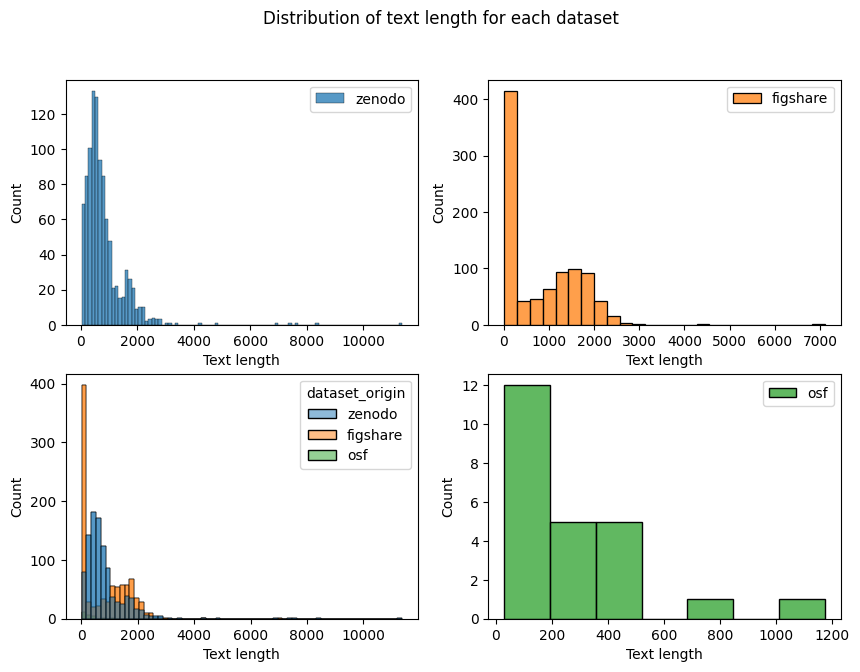

In [4]:
dataset_origin = ["zenodo", "figshare", "osf"]
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
for i in range(len(axs)):
    for j in range(i, len(axs[i])):
        sns.histplot(
            data=df[df["dataset_origin"] == dataset_origin[i+j]],
            x="text_length", 
            ax=axs[i, j], 
            color= "C" + str(i + j)
        )
        axs[i, j].legend([dataset_origin[i+j]])
        axs[i, j].set_xlabel("Text length")
        if i == j:
            sns.histplot(
                data=df,
                x="text_length",
                hue="dataset_origin",
                palette=["C0", "C1", "C2"],
                ax=axs[1, 0]
            )
            axs[1, 0].set_xlabel("Text length")
fig.suptitle("Distribution of text length for each dataset")
plt.show()

The histograms show us the number of datasets according to the length of their description. For example, we can see a large number of datasets coming from figshare where the length of their description is short. This distribution show us that our training dataset will be composed in large part by datasets coming from zenodo and figshare since we will prefer dataset that have a long description length.

### Describe for all datasets

In [5]:
pd.DataFrame(df["text_length"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
text_length,1948,811,795,15,184,594,1245,11363


For the selection of the training datasets, we will take the descriptive texte where their length is higher than the median, i.e. 594.

Selected threshold :  594.5
Number of text above the threshold :  974


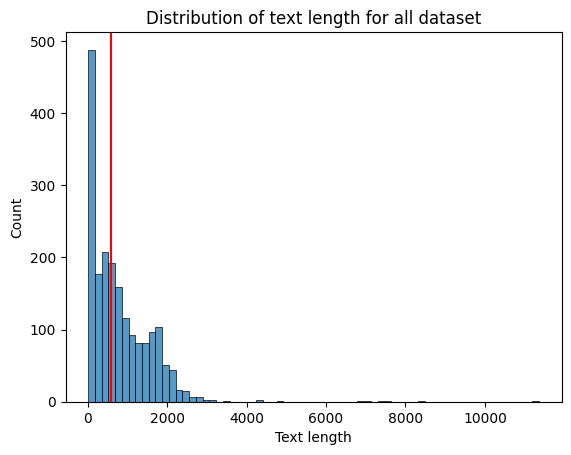

In [6]:
threshold = df["text_length"].describe()["50%"]
plt.title("Distribution of text length for all dataset")
sns.histplot(data=df, x="text_length")
plt.axvline(x = threshold, color = "red", label = 'axvline - full height')
plt.xlabel("Text length")
print("Selected threshold : ", threshold)
print("Number of text above the threshold : ", len(df[df["text_length"] > threshold]))
plt.show()

The threshold is the median value as shown with the red line. It should ensure that the number of descriptions is large to make sure a large training data. Here, we have 974 descriptions with a threshold = 594.

## Cosinus similarity

CPU times: user 2.46 s, sys: 93.2 ms, total: 2.55 s
Wall time: 2.4 s


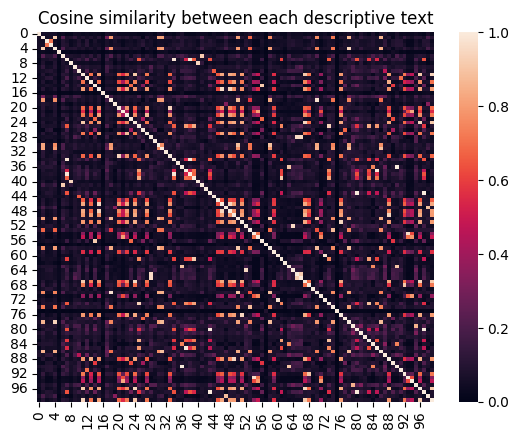

In [7]:
%%time
corpus_data = df[df["text_length"] > threshold].copy()[["text_dataset"]]
# Calcul the cosine similarity
vectorizer = TfidfVectorizer(stop_words="english")
trsfm = vectorizer.fit_transform(corpus_data["text_dataset"])
data = pd.DataFrame([cosine_similarity(trsfm[i:i+1], trsfm)[0] for i in range(len(corpus_data["text_dataset"]))])
heatmap = sns.heatmap(data.iloc[0:100, 0:100]).set(title="Cosine similarity between each descriptive text")

Here is a visualization of the similiarity between each descriptive text by using cosine similarity. The cosine similarity will allow us to select texts that are not very similar to make sure a good diversity of data. If a score is low then it's not similar.

## Annex

The objective of this part is to analyse the homogeneity of molecules data from GROMACS which is the most used software in the datasets. Here, we will analyze the gro files that contain information about the composition.

In [8]:
# Load gro data
gro = pd.read_parquet(
    "https://sandbox.zenodo.org/record/1169962/files/gromacs_gro_files.parquet"
)
# Merge to obtain the description with the associated gro file.
gro_data = pd.merge(
    gro,
    datasets,
    how="left",
    on=["dataset_id", "dataset_origin"],
    validate="many_to_one",
)

# Select gro files associed to the selected descriptions
gro_data.loc[:, "description_length"] = gro_data["description"].str.len() + gro_data["title"].str.len()
if gro_data["description_length"].isnull().values.any():
    gro_data = gro_data.dropna(subset=["description_length", "title", "description"])
gro_data = gro_data[gro_data["description_length"] > threshold]
print("Number of files: ", gro_data.shape[0])

Number of files:  6473


Here, we have 6473 gro files where many of files can be associated with a description.

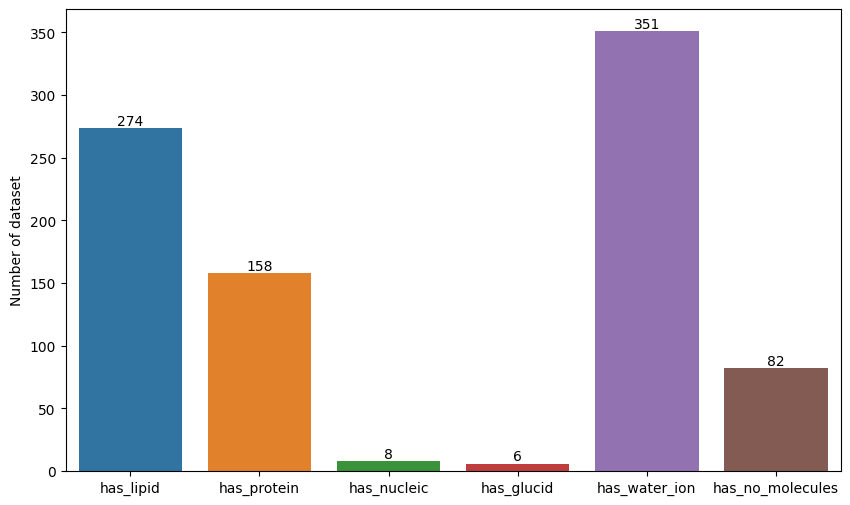

In [9]:
# Create has no molecules column
molecules = ["has_lipid","has_protein","has_nucleic","has_glucid","has_water_ion"]
gro_data["has_no_molecules"] = (~gro_data[molecules]).all(axis="columns")
# Get the number of descriptive text by molecules
composition_value = gro_data.groupby("dataset_id").agg(
    has_lipid=("has_lipid", "any"),
    has_protein=("has_protein", "any"),
    has_nucleic=("has_nucleic", "any"),
    has_glucid=("has_glucid", "any"),
    has_water_ion=("has_water_ion", "any"),
    has_no_molecules=("has_no_molecules", "any"),
).sum()
composition_value = pd.concat([composition_value], axis=0)
# Display the barplot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=composition_value.index, y=composition_value)
plt.ylabel("Number of dataset")
s = 0
for p in ax.patches:
    s += p.get_height()

for i, p in enumerate(ax.patches): 
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height(),
            f"{composition_value[i]}",
            ha='center',
            va='bottom')
plt.show()

The composition of the files does not guarantee that the associated text specifies the molecule in question. In addition, the texts do not necessarily have an associated gro file, which gives a total number of 801 datasets. It's possible that glucid datasets are more frequent in other file types. They will not help us to improve the quality of our training datasets because it's too ambiguous.